In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

In [4]:
biodiv = pd.read_excel("/Users/giacomorossini/Desktop/IRONHACK/Project2/FINAL/aggregate_exstintion_measure.xlsx")

In [5]:
#pivot 'UPPER' and 'LOWER' as columns
pivot_country_year = biodiv.pivot_table(index=['Country', 'Year'], columns='VAR', values='Value', aggfunc='mean').reset_index()

#calculate the average of 'UPPER' and 'LOWER' for each country and year
pivot_country_year['Country_Year_Average'] = pivot_country_year[['UPPER', 'LOWER']].mean(axis=1)

In [6]:
#applying time series on world to get the year and then mirror in the whole dataset
pivot_country_year_world = pivot_country_year[pivot_country_year['Country']=='World']

pivot_country_year_world['Year']=pd.to_datetime(pivot_country_year_world['Year'], format='%Y')
pivot_country_year_world.index = pd.DatetimeIndex(pivot_country_year_world['Year'])

In [7]:
#First method using ARIMA

from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
 
# evaluate an ARIMA model for a given order (p,d,q)

def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    # Ensure the dataset is of type float32
    dataset = dataset.astype('float32')
     # Initialize best_score with positive infinity
    best_score, best_cfg = float("inf"), None
    # Iterate over combinations of p, d, and q values
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    # Evaluate ARIMA model with the current order
                    rmse = evaluate_arima_model(dataset, order)
                     # Update best_score and best_cfg if a better combination is found
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    # Uncomment the following line if you want to print RMSE for each combination
                    #print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                     # Ignore exceptions and continue with the next combination
                    continue
     # Print the best ARIMA model configuration and its RMSE
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [8]:
series= pivot_country_year_world['Country_Year_Average']

#p: the number of lag observations in the model; also known as the lag order.
#d: the number of times that the raw observations are differenced; also known as the degree of differencing.
#q: the size of the moving average window; also known as the order of the moving average.
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
evaluate_models(series.values, p_values, d_values, q_values)

Best ARIMA(4, 1, 0) RMSE=0.001


In [9]:
model = ARIMA(pivot_country_year_world['Country_Year_Average'], order=(4,1,0))

# train model
model_fit = model.fit()
# make prediction
predictions = model_fit.predict(start = len(pivot_country_year_world['Country_Year_Average'])-20, end = len(pivot_country_year_world['Country_Year_Average'])-1)

In [10]:
pd.DataFrame({'observed':pivot_country_year_world.Country_Year_Average[-20:], 'predicted':predictions})

,observed,predicted
2002-01-01,0.7910,0.794500
2003-01-01,0.7875,0.788436
2004-01-01,0.7840,0.784914
2005-01-01,0.7805,0.780693
2006-01-01,0.7770,0.777091
2007-01-01,0.7735,0.773591
2008-01-01,0.7695,0.770091
2009-01-01,0.7650,0.765952
2010-01-01,0.7605,0.761439
2011-01-01,0.7580,0.756857


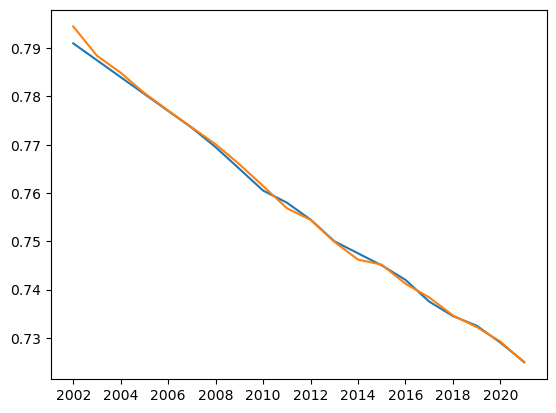

In [11]:
plt.plot(pivot_country_year_world.Country_Year_Average[-20:])
plt.plot(predictions)
plt.show()

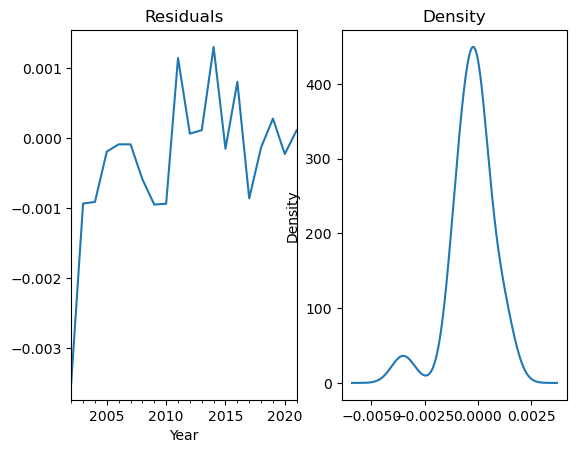

In [12]:
import matplotlib.pyplot as plt
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde',ax=ax[1])
plt.show()

#residuals show the model has low amount of data but is well fitted + density is well distributed w/ mean around 0 

In [13]:
# creating dataset to apply my prevision in ARIMA

from datetime import datetime, timedelta

start_year = 2022
end_year = 2200

year_list = [year for year in range(start_year, end_year + 1)]

In [14]:
#making prevision using ARIMA

n_periods = len(year_list)
fc = model_fit.forecast(n_periods, alpha=0.05)
final_prediction=pd.DataFrame({'COU':'World','Prediction':fc}).reset_index().rename(columns={'index':'Year'})

In [15]:
final_prediction

,Year,COU,Prediction
0,2022-01-01,World,0.722344
1,2023-01-01,World,0.720093
2,2024-01-01,World,0.716609
3,2025-01-01,World,0.712974
4,2026-01-01,World,0.710494
...,...,...,...
174,2196-01-01,World,0.437691
175,2197-01-01,World,0.436948
176,2198-01-01,World,0.436211
177,2199-01-01,World,0.435480


In [16]:
print(final_prediction[final_prediction['Prediction']<0.501111]) #2132 and 2133

          Year    COU  Prediction
110 2132-01-01  World    0.500263
111 2133-01-01  World    0.499014
112 2134-01-01  World    0.497778
113 2135-01-01  World    0.496551
114 2136-01-01  World    0.495332
..         ...    ...         ...
174 2196-01-01  World    0.437691
175 2197-01-01  World    0.436948
176 2198-01-01  World    0.436211
177 2199-01-01  World    0.435480
178 2200-01-01  World    0.434755

[69 rows x 3 columns]


In [17]:
#making prevision applying linear regression model 

# limit predictions within the range [0, 1]
def bound_predictions(prediction):
    return min(max(prediction, 0), 1)

# Prepare a DataFrame to store bounded predictions for 2100
bounded_predictions_2100 = pd.DataFrame(columns=['Country', '2100_Bounded_Prediction'])

# Fit a linear regression model for each country and predict the value for 2100
for country in pivot_country_year['Country'].unique():
    # Filter the data for the current country
    country_data = pivot_country_year[pivot_country_year['Country'] == country]
    # Prepare the features (Year) and target (Country_Year_Average)
    X = country_data[['Year']].values
    Y = country_data['Country_Year_Average'].values
 
    model = LinearRegression()
    model.fit(X, Y)
    
    # Predict the value for 2100
    prediction = model.predict(np.array([[2100]]))[0]
    # Bound the prediction
    bounded_prediction = bound_predictions(prediction)
    # Append the bounded prediction to the DataFrame
    bounded_predictions_2100 = bounded_predictions_2100.append({'Country': country, '2100_Bounded_Prediction': bounded_prediction}, ignore_index=True)

print(bounded_predictions_2100)

            Country  2100_Bounded_Prediction
0       Afghanistan                 0.818930
1           Albania                 0.636480
2           Algeria                 0.886647
3    American Samoa                 0.798022
4           Andorra                 0.899877
..              ...                      ...
235           World                 0.448227
236           Yemen                 0.610842
237          Zambia                 0.866130
238        Zimbabwe                 0.760682
239           Åland                 0.957310

[240 rows x 2 columns]


In [95]:
#merging bounded_predictions_2100 & KPI: red_list_ind
red_list_index = pd.read_excel("/Users/giacomorossini/Desktop/IRONHACK/Project2/FINAL/DATA/red-list-index.xlsx")
red_list_index.rename(columns={'Entity':'Country'}, inplace= True)
bounded_pred_RLI= pd.merge(pivot_country_year, red_list_index, how='left', on=['Year','Country'])

In [97]:
bounded_pred_RLI.to_excel("/Users/giacomorossini/Desktop/IRONHACK/Project2/FINAL/avg_cou_biod_2021_RLI.xlsx", index=False)

In [98]:
bounded_predictions_2100.to_excel("/Users/giacomorossini/Desktop/IRONHACK/Project2/FINAL/bounded_predictions_2100.xlsx", index=False)

In [99]:
final_prediction.to_excel("/Users/giacomorossini/Desktop/IRONHACK/Project2/FINAL/ARIMA_forecast_world.xlsx", index=False)